# Configuation

In [23]:
# System and utilities
import os
import re
import time
import io
import base64
from collections import Counter

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Machine Learning & Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## importing helper functions:
import sys
sys.path.append('../src/functions')
from image_helpers import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing and display
from PIL import Image
from IPython.display import display
from IPython.core.display import HTML
import cv2

# Progress bars
from tqdm import tqdm
warnings.filterwarnings('ignore')

DATA_TEST_LENGTH = 0

In [26]:
DATA_PATH = '../data/'
PROC_DATA_PATH = '../processed_data/'
df = pd.read_csv(PROC_DATA_PATH  + 'X_train_with_labels_ext.csv', index_col=0)
df = df.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else df

## Set to 'True' to run all the cells and analysis
### False if you did it already and want to import the csv results from existing files
# run_analysis=True
run_analysis=False

## Image table exploration
##  LONG RUNTIME WARNING

In [27]:
if run_analysis:
    
    print('Running image / path preprocessing...')
    # Creating a data_frame with image data
    #image_directory = '../data/images_bgrm/image_train/'
    #orig_image_directory = '../data/images/image_train/'
    #orig_image_directory = '../data/images/image_test/'
    image_directory = '../data/processed_advanced/image_train/'
    image_directory_test = '../data/processed_advanced/image_test/'

    pattern = re.compile(r'image_(\d+)_product_(\d+)\_advanced.png')
    #pattern = re.compile(r'image_(\d+)_product_(\d+)\.jpg')

    data_for_dataframe = []
    image_files = os.listdir(image_directory)

    for image_file_name in image_files:
        #print(f"Processing file: {image_file_name}")
        match = pattern.match(image_file_name)
        if match:
            print(f"Processing file: {image_file_name}")
            imageid = match.group(1)
            productid = int(match.group(2))
            full_image_path = os.path.join(image_directory, image_file_name)
            product_matches = df.loc[df['productid'] == productid, 'prdtypecode']
            prdtypecode = product_matches.values[0] if len(product_matches) > 0 else None

            data_for_dataframe.append({
                'productid': productid,
                'imageid': imageid,
                'imagepath': full_image_path,
                #'imagepath_orig': orig_full_image_path,
                'prdtypecode': prdtypecode
            })

    data_for_dataframe_test = []

    image_files_test = os.listdir(image_directory_test)

    for image_file_name in image_files_test:

        #print(f"Processing file: {image_file_name}")
        match = pattern.match(image_file_name)
        if match:
            imageid = match.group(1)
            productid = int(match.group(2))
            full_image_path = os.path.join(image_directory_test, image_file_name)
            product_matches = df.loc[df['productid'] == productid, 'prdtypecode']
            prdtypecode = product_matches.values[0] if len(product_matches) > 0 else None

            data_for_dataframe_test.append({
                'productid': productid,
                'imageid': imageid,
                'imagepath': full_image_path,
                'prdtypecode': prdtypecode
            })


    #local save 
    df_img = pd.DataFrame(data_for_dataframe)
    df_img_test = pd.DataFrame(data_for_dataframe_test)
    df_img.to_csv(DATA_PATH + 'df_imgpaths_adv_train.csv')
    df_img_test.to_csv(DATA_PATH + 'df_imgpaths_adv_test.csv')

else:
    print('Importing image analysis results...')
    #df_img = pd.read_csv(DATA_PATH + 'df_imgpaths.csv', index_col=0)
    df_img = pd.read_csv(DATA_PATH + 'df_imgpaths_adv_train.csv', index_col=0)
    df_img = df_img.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else df_img
    df_img_test = pd.read_csv(DATA_PATH + 'df_imgpaths_adv_test.csv', index_col=0)
    df_img_test = df_img_test.head(DATA_TEST_LENGTH) if DATA_TEST_LENGTH != 0 else df_img_test

Importing image analysis results...


In [28]:
df_img.columns

Index(['productid', 'imageid', 'imagepath', 'prdtypecode'], dtype='object')

In [29]:
df.columns
#df = df.drop(columns=['description', 'cat_name_fr', 'combined'])DATA_TEST_LENGTH)
df.shape
df_img['imageid'] = df_img['imageid'].astype(int)

In [30]:
df_full = df.merge(df_img, on=['productid', 'imageid', 'prdtypecode'],how='left')
print(df_full.columns)
df_full.shape

Index(['description', 'productid', 'imageid', 'prdtypecode', 'cat_name_fr',
       'cat_name_en', 'combined', 'comb_tokens_fr', 'imagepath'],
      dtype='object')


(84916, 9)

In [31]:
df_full = df_full.drop(columns=['description', 'cat_name_fr', 'combined'])
df_full.to_csv(PROC_DATA_PATH + 'X_train_multimodal.csv')

In [32]:
df_full.head()

,productid,imageid,prdtypecode,cat_name_en,comb_tokens_fr,imagepath
0,3804725264,1263597046,10,Used Books,"['olivia', 'personnalise', 'sites', 'din', 'ro...",../data/processed_advanced/image_train/image_1...
1,436067568,1008141237,2280,Magazines and Journals,"['journal', 'arts', 'art', 'marche', 'salon', ...",../data/processed_advanced/image_train/image_1...
2,201115110,938777978,50,Video Game Accessories,"['stylet', 'ergonomique', 'gamepad', 'nintendo...",../data/processed_advanced/image_train/image_9...
3,50418756,457047496,1280,Toys,"['peluche', 'donald', 'europe', 'disneyland', ...",../data/processed_advanced/image_train/image_4...
4,278535884,1077757786,2705,New Books,"['guerre', 'tuques', 'luc', 'grandeur', 'veut'...",../data/processed_advanced/image_train/image_1...


### BASIC IMAGE ANALYSIS
- sub FUNCTIONS were imported from src/functions/
- this function runs them all at once

In [33]:
#df = df.head(10000)
def basic_image_analysis(df, sharp_thr = 100., bright_thr=50. , verbose=True):
    results = []
    for idx, row in df.iterrows():
        path = row['imagepath']
        # Basic checks
        exists = os.path.exists(path)
        if not exists:
            results.append({
                'productid': row['productid'],
                'imageid': row['imageid'], 
                'exists': False,
                'width': None, 'height': None,
                'sharpness': None, 'is_sharp': False,
                'brightness': None, 'is_bright': False,
                'rgb': None 
            })

        w, h, num_pixels = get_image_size(path)
        if w != 500 or h != 500:
            print(f'Image {row["imageid"]} has unexpected size: {w}x{h} pixels')
        #print(f'Image {row['imageid']} - Width: {w}, Height: {h}, Pixels: {num_pixels}')

        blur_score, is_sharp = get_blur_score(path, thr=sharp_thr)
        if not is_sharp and verbose:
            print(f'Image {row["imageid"]} is blurry with score: {blur_score}')      
        #print(f' Image {row["imageid"]} -> Blur Score: {blur_score}, Is Sharp: {is_sharp}')

        brightness, is_bright = get_brightness(path, thr=bright_thr)
        if not is_bright and verbose:
            print(f'Image {row["imageid"]} is dark with brightness: {brightness}')
        #print(f' ----- > Brightness: {brightness}')
        try:
            avg_rgb, col_type, contrast = get_rgb(path)
        except Exception as e:
            print(f'Error processing image {row["imageid"]}: {e}')
            avg_rgb, col_type, contrast = None, None, None
        
        results.append({
            'productid': row['productid'],
            'imageid': row['imageid'], 'imagepath': path,
            'exists': exists,
            'width': w, 'height': h,
            'sharpness': blur_score, 'is_sharp': is_sharp,
            'brightness': brightness,'is_bright': is_bright,
            'average_rgb': avg_rgb,'color_type': col_type,'contrast': contrast
        })
        if idx % 1000 == 0 and verbose:
            print(f'Processed {idx} images out of {len(df)}')
    return results


In [34]:
## LONG RUNTIME WARNING:
run_analysis=False
if run_analysis:
    results = basic_image_analysis(df_img, verbose=False)
    results_df = pd.DataFrame(results)
    # Save the results to a CSV file (non-shared)
    results_df.to_csv(DATA_PATH + 'image_analysis_results_bgrm.csv', index=False)
else:
    results_df = pd.read_csv(DATA_PATH + 'image_analysis_results_bgrm.csv')
    
results_df.head()

,productid,imageid,imagepath,exists,width,height,sharpness,is_sharp,brightness,is_bright,average_rgb,color_type,contrast
0,3775275629,1243659977,/Users/jansta/learn/DS-bootcamp/apr25_bds_raku...,True,500,500,339.265944,True,42.5,False,"(np.float64(42.250848), np.float64(41.396536),...",greyscale,68.26
1,3971761681,1270628131,/Users/jansta/learn/DS-bootcamp/apr25_bds_raku...,True,500,500,173.600075,True,26.2,False,"(np.float64(26.881196), np.float64(25.582656),...",greyscale,65.33
2,435040427,1007590355,/Users/jansta/learn/DS-bootcamp/apr25_bds_raku...,True,500,500,1381.440267,True,128.3,True,"(np.float64(134.222884), np.float64(131.974656...",color,82.42
3,3969082015,1270129781,/Users/jansta/learn/DS-bootcamp/apr25_bds_raku...,True,500,500,4641.425240,True,102.6,True,"(np.float64(118.89782), np.float64(84.874516),...",color,89.30
4,518435865,1019973492,/Users/jansta/learn/DS-bootcamp/apr25_bds_raku...,True,500,500,266.598752,True,40.0,False,"(np.float64(43.715552), np.float64(37.696128),...",greyscale,79.39


In [35]:
results_df.columns

Index(['productid', 'imageid', 'imagepath', 'exists', 'width', 'height',
       'sharpness', 'is_sharp', 'brightness', 'is_bright', 'average_rgb',
       'color_type', 'contrast'],
      dtype='object')

In [36]:
### get the summary statistics using helper function get_summary(results_df)

get_summary(results_df)

{'total_images': 84916,
 'missing_images': 0,
 'avg_sharpness': 671.9243312676888,
 'sharp_images': 0.8572471619011729,
 'avg_brightness': 43.469460407932544,
 'bright_images': 0.3501931320363654,
 'contrast': 62.92898252390598,
 'color_types': {'greyscale': 49356, 'color': 32986, 'full_black': 2574}}

### Visualize the results

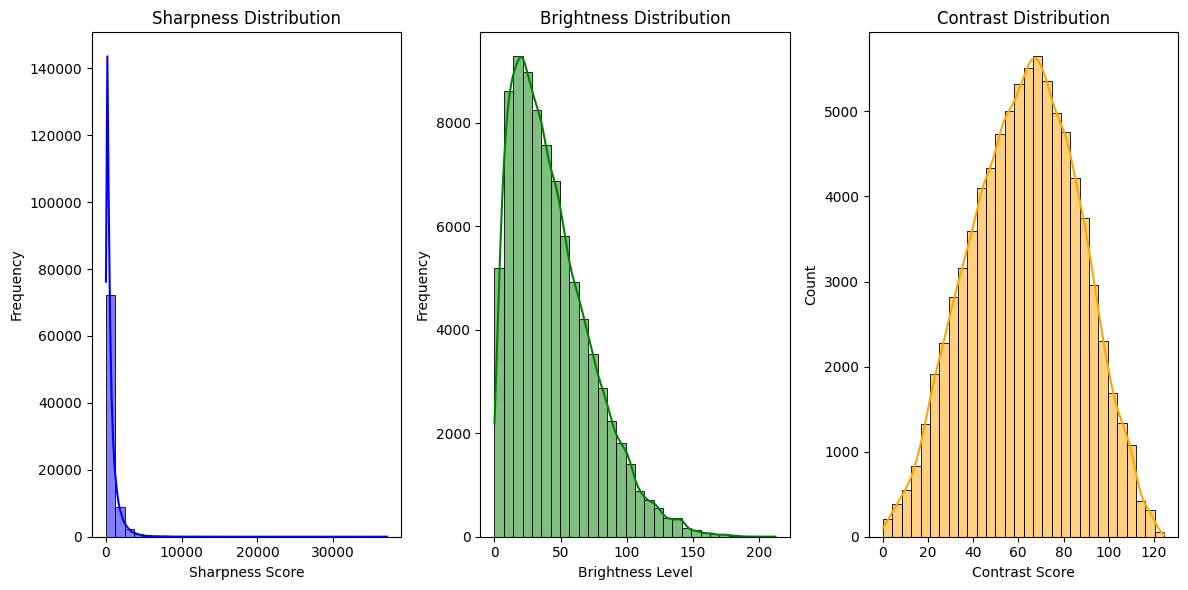

In [13]:
def plot_image_analysis(results_df):
    plt.figure(figsize=(12, 6))
    # Sharpness distribution
    plt.subplot(1, 3, 1)
    sns.histplot(results_df['sharpness'], bins=30, kde=True, color='blue')
    plt.title('Sharpness Distribution')
    plt.xlabel('Sharpness Score')
    plt.ylabel('Frequency')

    # Brightness distribution
    plt.subplot(1, 3, 2)
    sns.histplot(results_df['brightness'], bins=30, kde=True, color='green')
    plt.title('Brightness Distribution')
    plt.xlabel('Brightness Level')
    plt.ylabel('Frequency')
    

    plt.subplot(1, 3, 3)
    sns.histplot(results_df['contrast'], bins=30, kde=True, color='orange')
    plt.xlabel('Contrast Score')
    plt.ylabel('Count')
    plt.title('Contrast Distribution')
    plt.tight_layout()

plot_image_analysis(results_df)

<Axes: xlabel='color_type'>

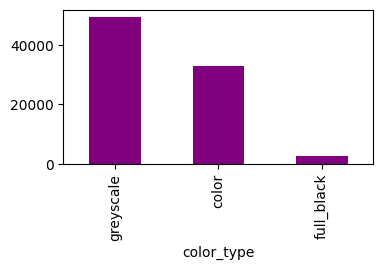

In [14]:
results_df['color_type'].value_counts().plot(kind='bar', figsize=(4, 2), color='purple')

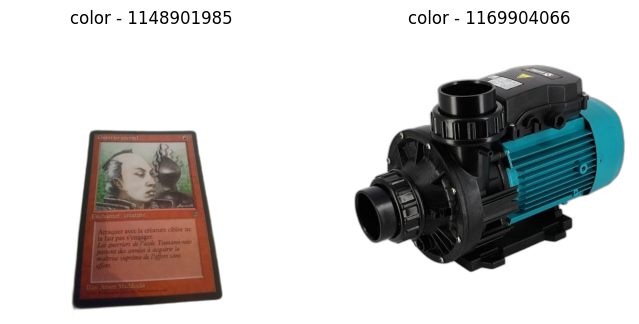

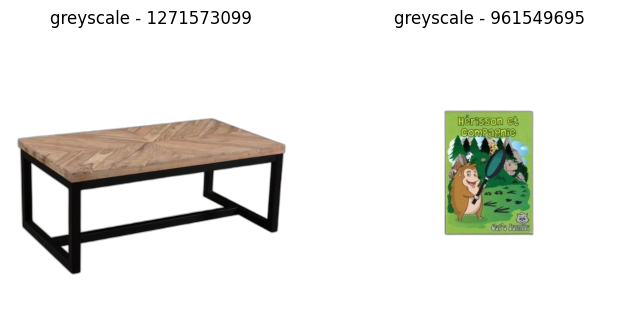

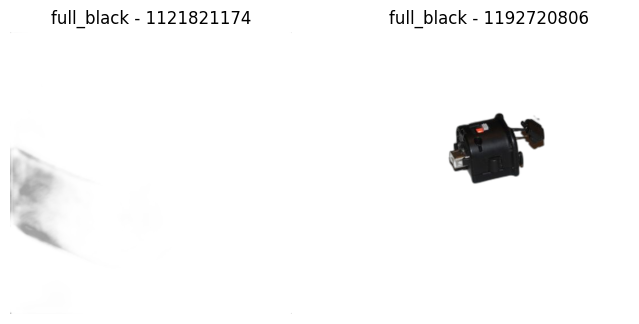

In [15]:
for color_type in ['color', 'greyscale', 'full_black']:
   type_data = results_df[results_df['color_type'] == color_type]
   
   if len(type_data) == 0:
       print(f"No {color_type} images found")
       continue
       
   samples = type_data.sample(min(2, len(type_data)))
   
   fig, axes = plt.subplots(1, 2, figsize=(8, 4))
   
   for i, (_, row) in enumerate(samples.iterrows()):
       img = Image.open(row['imagepath'])
       axes[i].imshow(img)
       axes[i].set_title(f"{color_type} - {row['imageid']}")
       axes[i].axis('off')

### Flattening the images for basic modeling

In [16]:
img_size=128

def flatten_image(image_path, size=img_size):
    """Convert image to flat array"""
    try:
        img = Image.open(image_path).convert('RGB').resize((size, size))
        return np.array(img).flatten()
    except:
        return None

def flatten_all_images(df, size=img_size):
    flat_results = []
    for _, row in df.iterrows():
        flat_img = flatten_image(row['imagepath'], size)
        if flat_img  is not None:
            flat_results.append({
                'productid': row['productid'],
                'imageid': row['imageid'],
                'pixels': flat_img 
            })
    
    return pd.DataFrame(flat_results)

In [17]:
## LONG RUNTIME WARNING:
img_size = 128

if run_analysis:
    for s in [32, 64, 128, 500]:
        flat_res = flatten_all_images(df_img, size=s)
        flat_res.to_csv(PROC_DATA_PATH + f'flattened_images_{s}.csv', index=False)
else:
    flat_res = pd.read_csv(PROC_DATA_PATH + f'flattened_images_{img_size}.csv')

flat_res.head(3)


,productid,imageid,pixels
0,3775275629,1243659977,[0 0 0 ... 0 0 0]
1,3971761681,1270628131,[2 2 2 ... 2 2 2]
2,435040427,1007590355,[0 0 0 ... 0 0 0]


In [18]:
df_img['imagepath'][:3]

0    ../data/processed_advanced/image_train/image_1...
1    ../data/processed_advanced/image_train/image_9...
2    ../data/processed_advanced/image_train/image_1...
Name: imagepath, dtype: object

In [19]:
df_img['imagepath_orig'] = df_img['imagepath']

In [20]:
# import matplotlib.pyplot as plt

# # Select a product category
# product_category = df['productid'].iloc[0]  # Replace with desired product category
# selected_images = df[df['productid'] == product_category].sample(4, random_state=42)

# fig, axes = plt.subplots(4, 2, figsize=(10, 15))

# for i, (_, row) in enumerate(selected_images.iterrows()):
#     image_path = row['imagepath']
    
#     # Original image
#     with Image.open(image_path) as img:
#         axes[i, 0].imshow(img)
#         axes[i, 0].axis('off')
#         axes[i, 0].set_title('Original Image')
    
#     # Masked image
#     mask, _, _ = get_bw_mask(image_path)
#     with Image.open(image_path) as img:
#         img_array = np.array(img)
#         masked_img = img_array.copy()
#         masked_img[~mask] = 0
#         axes[i, 1].imshow(masked_img)
#         axes[i, 1].axis('off')
#         axes[i, 1].set_title('Masked Image')

# plt.tight_layout()
# plt.show()

# # Ensure there are at least 4 images for the selected product category
# if len(selected_images) < 4:
#     print(f"Not enough images for product category {product_category}.")
# else:
#     plt.show()

### LOOKING INTO IMAGE PREPROCESSING APPROACHES:
- The functions are stored in the image_helpers.py file

In [21]:

# Additional functions:
from preprocessing_functions import *

Four Preprocessing Methods:
1. Baseline (Simple)

- Basic resize + normalize only
- Minimal processing for speed
- Good baseline for comparison

2. Background Removal

- Uses AI-powered rembg library to isolate products
- Removes distracting backgrounds automatically
- Enhances contrast slightly
- Best for: Product-focused classification where backgrounds add noise

3. Smart Crop

- Edge detection finds product boundaries
- Intelligent cropping with padding around detected objects
- Histogram equalization improves contrast
- Fallback to center crop if detection fails
- Best for: Variable product sizes, focusing on product details

4. Advanced Augmentation

- Denoising: Removes image artifacts and noise
- CLAHE: Adaptive contrast enhancement in localized regions
- Sharpening: Enhances edge definition and details
- Color balance: Improves color consistency across images
- Best for: Poor quality images, maximizing feature extraction

In [22]:
# Option 1: Process sample with saving (memory efficient)
N = 500
save_directory = '../data/processed_images/'

paths, baseline_imgs, bg_removed_imgs, smart_crop_imgs, advanced_imgs = process_all_methods_memory_efficient(
    df_img, n_samples=N, save_processed=False, save_dir=save_directory
)

Processed: 1/500, Successful: 1


KeyboardInterrupt: 

In [ ]:
# Display comparison (now shows 5 methods)
display_preprocessing_comparison_4methods(paths, baseline_imgs, bg_removed_imgs, smart_crop_imgs, advanced_imgs)

This pipeline lets you empirically test which preprocessing approach works best for your specific product types and CNN architecture.

 - Batch processing prevents memory overflow
 - Selective retention keeps only 50 images in memory for visualization
 - Automatic saving stores processed images to disk
 - Progress tracking monitors large dataset processing

In [ ]:
### Long Runtime Warning:
df_img.shape
df_img_test.shape

In [ ]:
process_entire_dataset(df_img, '../data/processed_advanced/image_test/', batch_size=100, method='advanced')

In [ ]:
process_entire_dataset(df_img, '../data/processed_baseline/image_test/', batch_size=100, method='baseline')

In [ ]:
# 6x6 grid display for baseline vs advanced comparison
def display_baseline_vs_advanced_6x6(image_paths, baseline_imgs, advanced_imgs):
    """
    Display 6x6 grid alternating between Baseline (B) and Advanced (A)
    Pattern: B, A, B, A, B, A per row
    """
    
    # Need 18 images total (3 per row * 6 rows)
    n_images_needed = 18
    
    if len(image_paths) < n_images_needed:
        n_images_needed = len(image_paths)
    
    # Randomly select images
    indices = random.sample(range(len(image_paths)), n_images_needed)
    
    fig, axes = plt.subplots(6, 6, figsize=(18, 18))
    
    img_counter = 0
    
    for row in range(6):
        for col in range(6):
            if img_counter < len(indices):
                idx = indices[img_counter]
                
                # Alternate between Baseline (B) and Advanced (A)
                if col % 2 == 0:  # Even columns: Baseline
                    img = baseline_imgs[idx]
                    method = 'Baseline'
                else:  # Odd columns: Advanced
                    img = advanced_imgs[idx]
                    method = 'Advanced'
                
                axes[row, col].imshow(img)
                axes[row, col].set_title(f'{method}', fontsize=10)
                axes[row, col].axis('off')
                
                # Move to next image every 2 columns (after showing both B and A)
                if col % 2 == 1:
                    img_counter += 1
            else:
                # Hide empty subplots
                axes[row, col].axis('off')
    
    plt.tight_layout()

In [ ]:
display_baseline_vs_advanced_6x6(paths, baseline_imgs, advanced_imgs)